100%|██████████| 170498071/170498071 [00:02<00:00, 82644895.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 157/157 [01:05<00:00,  2.41it/s]


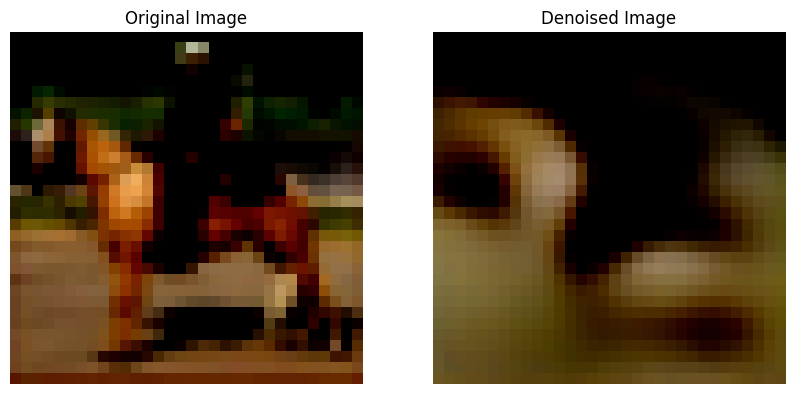

Epoch 1/20, Train Loss: 0.0104, Test Loss: 0.0092, SSIM Score: 0.2999


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


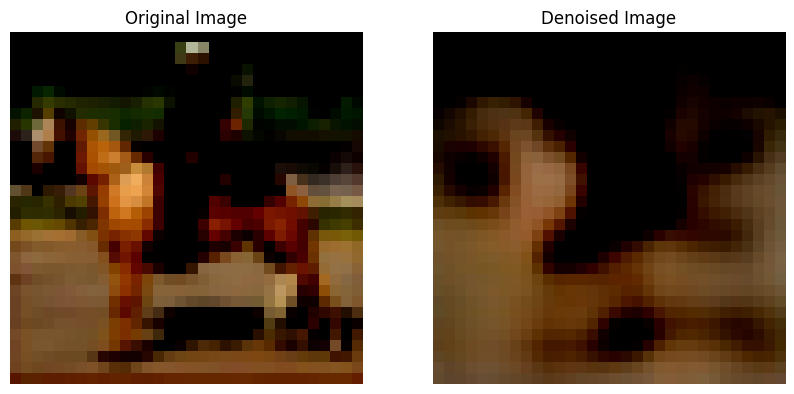

Epoch 2/20, Train Loss: 0.0062, Test Loss: 0.0061, SSIM Score: 0.3781


100%|██████████| 157/157 [01:04<00:00,  2.43it/s]


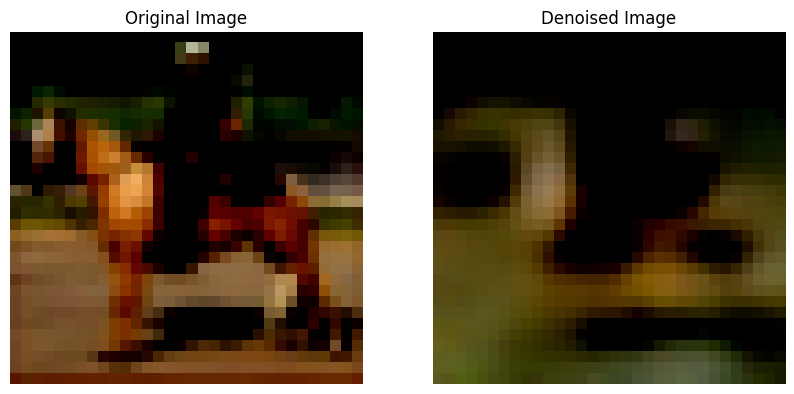

Epoch 3/20, Train Loss: 0.0051, Test Loss: 0.0062, SSIM Score: 0.3844


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


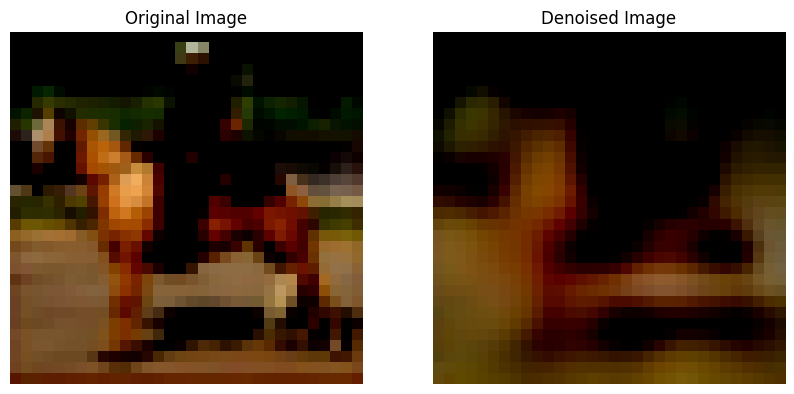

Epoch 4/20, Train Loss: 0.0046, Test Loss: 0.0055, SSIM Score: 0.4105


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


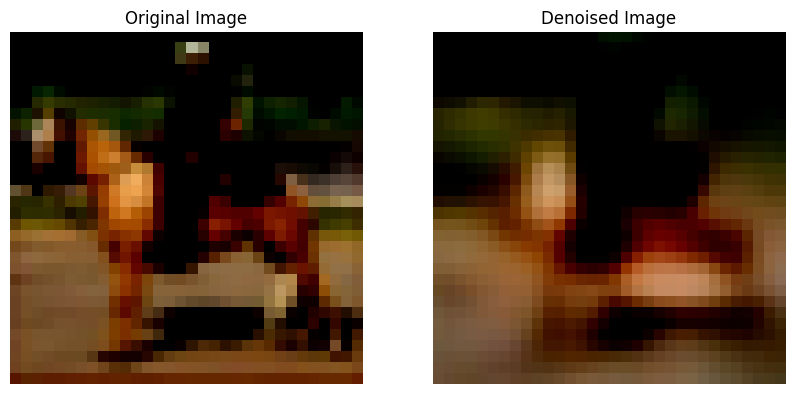

Epoch 5/20, Train Loss: 0.0042, Test Loss: 0.0046, SSIM Score: 0.4451


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


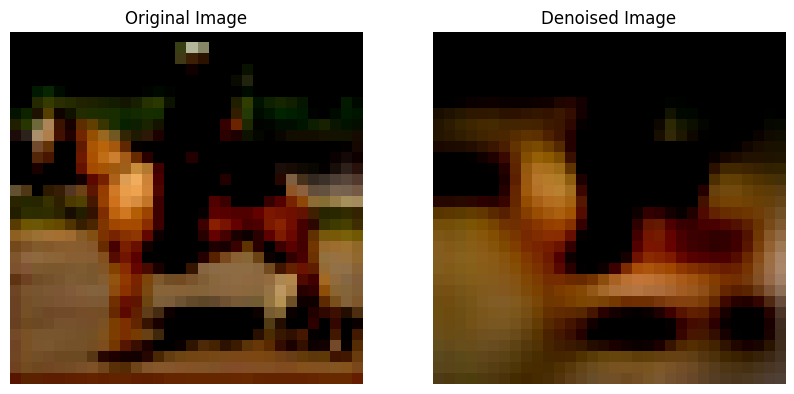

Epoch 6/20, Train Loss: 0.0039, Test Loss: 0.0045, SSIM Score: 0.4558


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


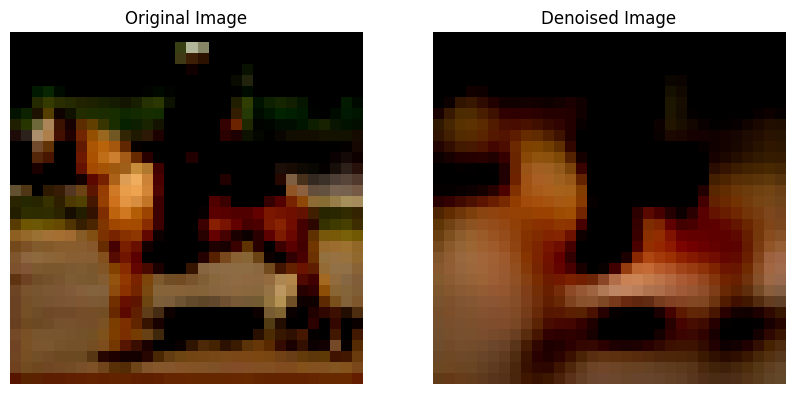

Epoch 7/20, Train Loss: 0.0037, Test Loss: 0.0039, SSIM Score: 0.4818


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


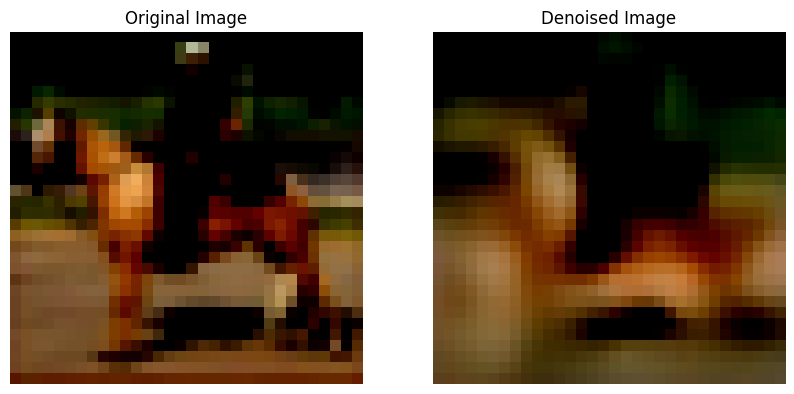

Epoch 8/20, Train Loss: 0.0035, Test Loss: 0.0041, SSIM Score: 0.4775


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


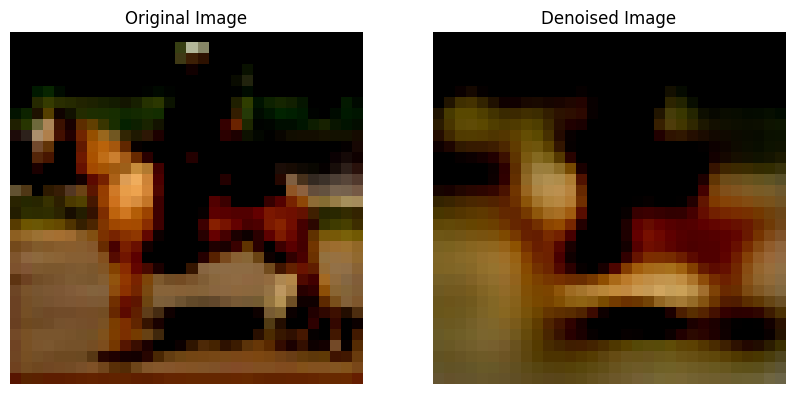

Epoch 9/20, Train Loss: 0.0034, Test Loss: 0.0039, SSIM Score: 0.4884


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


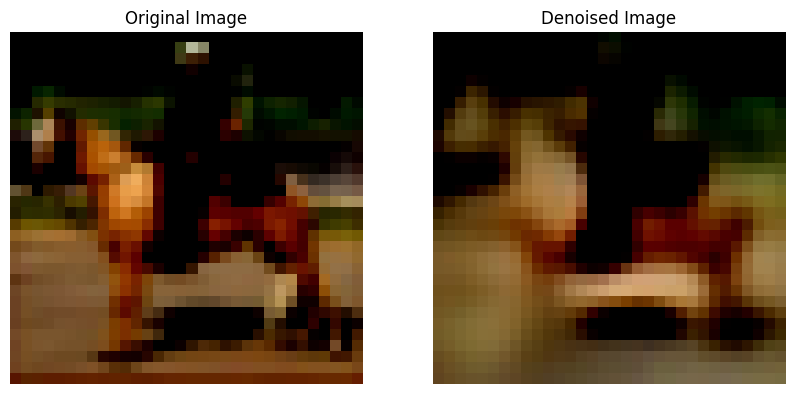

Epoch 10/20, Train Loss: 0.0033, Test Loss: 0.0045, SSIM Score: 0.4703


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


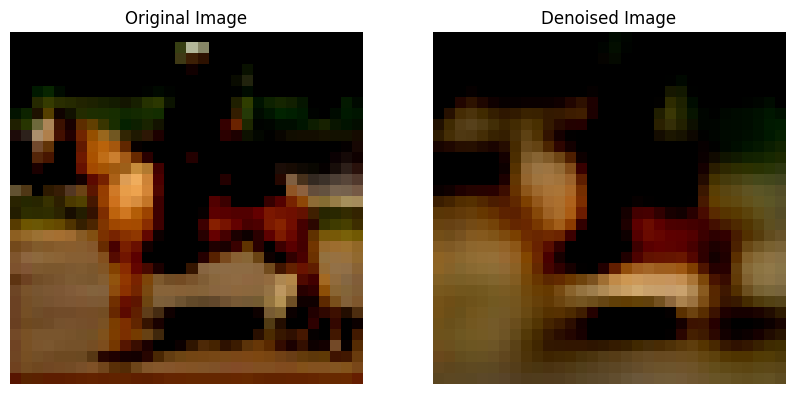

Epoch 11/20, Train Loss: 0.0032, Test Loss: 0.0033, SSIM Score: 0.5204


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


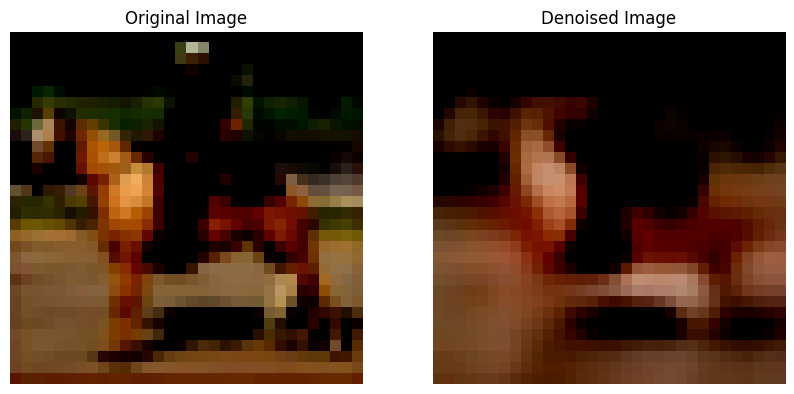

Epoch 12/20, Train Loss: 0.0031, Test Loss: 0.0037, SSIM Score: 0.4977


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


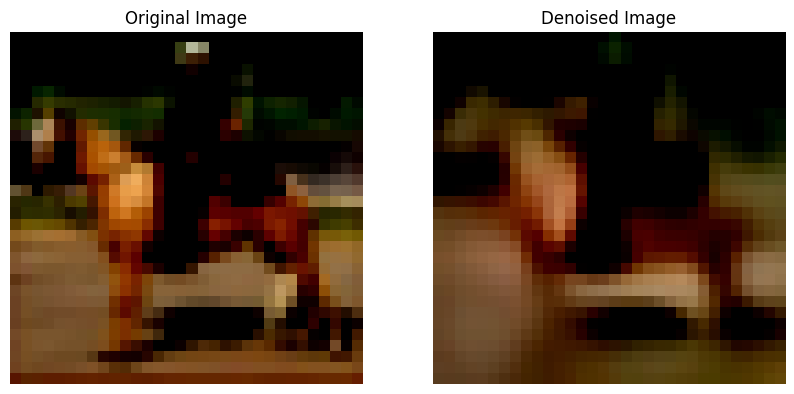

Epoch 13/20, Train Loss: 0.0030, Test Loss: 0.0034, SSIM Score: 0.5257


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


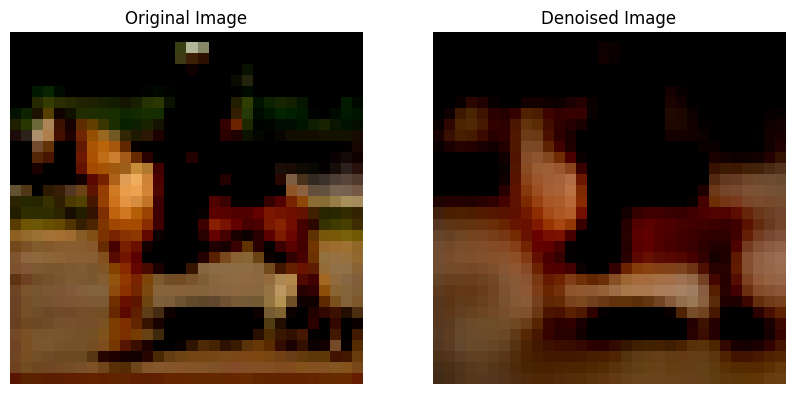

Epoch 14/20, Train Loss: 0.0029, Test Loss: 0.0040, SSIM Score: 0.4930


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


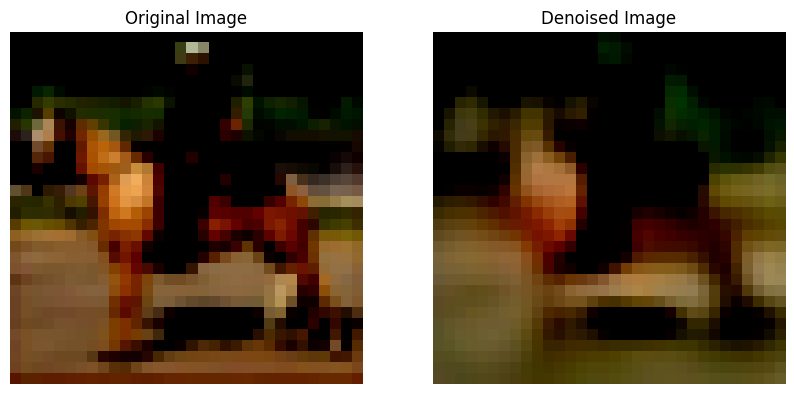

Epoch 15/20, Train Loss: 0.0029, Test Loss: 0.0031, SSIM Score: 0.5386


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


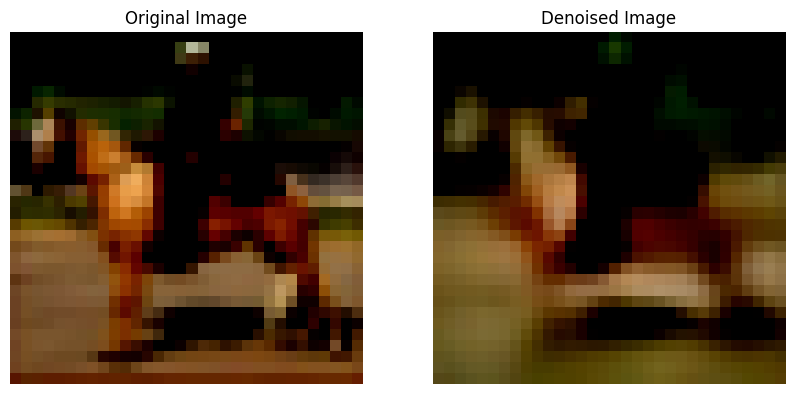

Epoch 16/20, Train Loss: 0.0028, Test Loss: 0.0036, SSIM Score: 0.5225


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


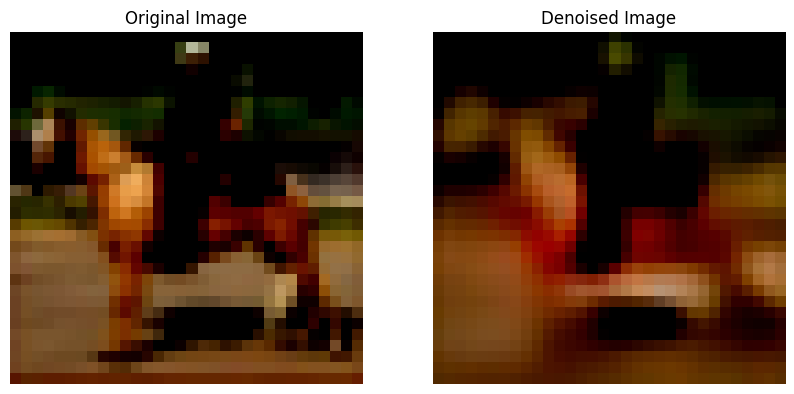

Epoch 17/20, Train Loss: 0.0028, Test Loss: 0.0043, SSIM Score: 0.4878


100%|██████████| 157/157 [01:04<00:00,  2.44it/s]


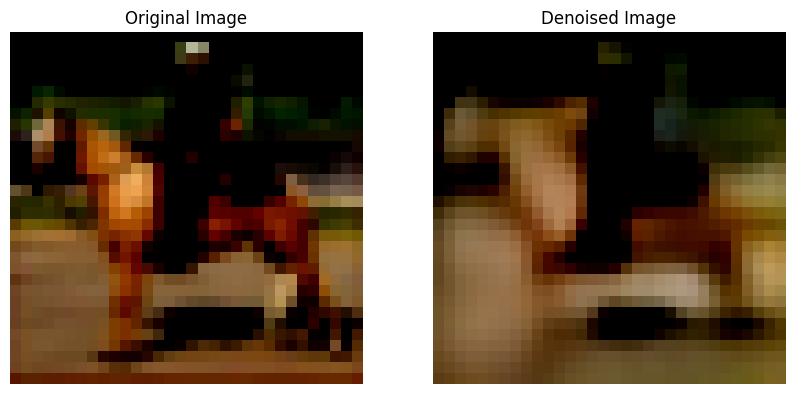

Epoch 18/20, Train Loss: 0.0028, Test Loss: 0.0044, SSIM Score: 0.4831


100%|██████████| 157/157 [01:04<00:00,  2.45it/s]


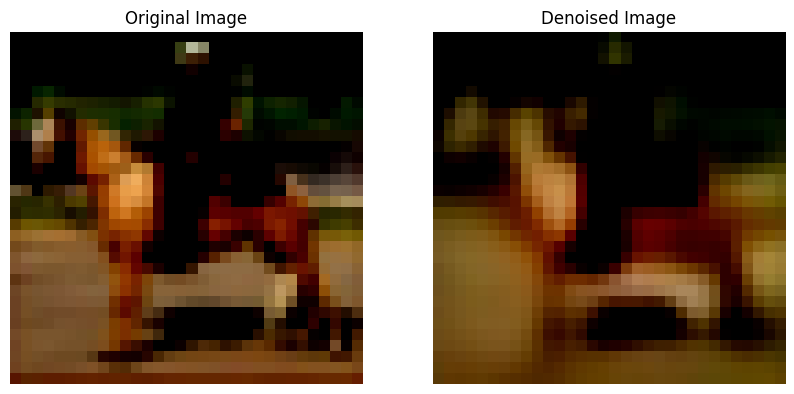

Epoch 19/20, Train Loss: 0.0027, Test Loss: 0.0031, SSIM Score: 0.5439


100%|██████████| 157/157 [01:03<00:00,  2.46it/s]


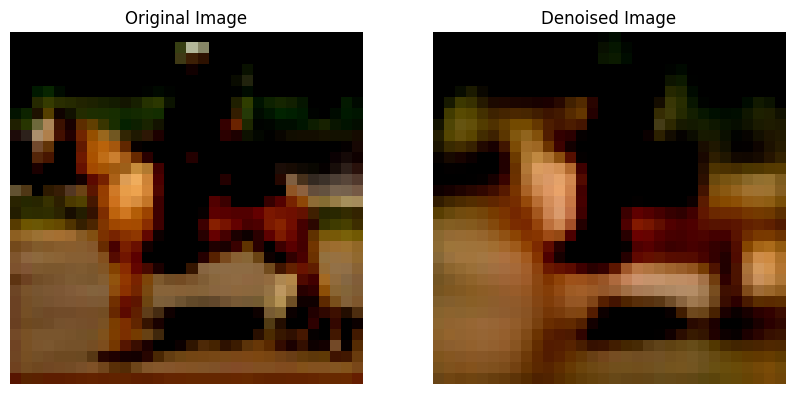

Epoch 20/20, Train Loss: 0.0027, Test Loss: 0.0040, SSIM Score: 0.5118


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the DDPM model
class DDPM(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=3, num_blocks=4):
        super(DDPM, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.num_blocks = num_blocks

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            *[
                nn.Sequential(
                    nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                )
                for _ in range(num_blocks)
            ]
        )

        self.decoder = nn.Sequential(
            *[
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.ReLU(),
                    nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                )
                for _ in range(num_blocks)
            ],
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x, noise):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded + noise)
        return decoded

# Define the training and testing functions
def train(model, device, train_loader, optimizer, noise_schedule, num_steps):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        batch_size = data.size(0)

        for step in range(num_steps):
            noise_level = torch.rand(batch_size, 1, 1, 1).to(device)
            noise = noise_schedule(noise_level)

            noisy_data = data + noise
            denoised = model(noisy_data, noise)

            loss = F.mse_loss(denoised, data)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    train_loss /= len(train_loader.dataset)
    return train_loss


def test(model, device, test_loader, noise_schedule, num_steps, count):
    model.eval()
    test_loss = 0
    ssim_scores = []

    with torch.no_grad():
        for data, _ in tqdm(test_loader):
            data = data.to(device)
            batch_size = data.size(0)

            for step in range(num_steps):
                noise_level = torch.rand(batch_size, 1, 1, 1).to(device)
                noise = noise_schedule(noise_level)

                noisy_data = data + noise
                denoised = model(noisy_data, noise)

                loss = F.mse_loss(denoised, data)
                test_loss += loss.item()

                for i in range(batch_size):
                    ssim_scores.append(ssim(denoised[i], data[i]))
        
        orig_image = data[0].permute(1, 2, 0).cpu().numpy()
        denoised_image = denoised[0].permute(1, 2, 0).cpu().detach().numpy()

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(orig_image)
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(denoised_image)
        ax[1].set_title("Denoised Image")
        ax[1].axis('off')

        plt.show()
    test_loss /= len(test_loader.dataset)
    mean_ssim = sum(ssim_scores) / len(ssim_scores)
    return test_loss, mean_ssim

# Define the noise schedule
def noise_schedule(noise_level):
    return torch.randn_like(noise_level) * noise_level

# Define the SSIM function
def ssim(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu_x = nn.AvgPool2d(3, 1, 1)(x)
    mu_y = nn.AvgPool2d(3, 1, 1)(y)

    sigma_x = nn.AvgPool2d(3, 1, 1)(x ** 2) - mu_x ** 2
    sigma_y = nn.AvgPool2d(3, 1, 1)(y ** 2) - mu_y ** 2
    sigma_xy = nn.AvgPool2d(3, 1, 1)(x * y) - mu_x * mu_y

    ssim_value = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / ((mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2))
    return ssim_value.mean()

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, optimizer, and noise schedule
model = DDPM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
noise_schedule = noise_schedule

# Train and test the model
num_epochs = 20
num_steps = 10
count = 1
for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, optimizer, noise_schedule, num_steps)
    test_loss, ssim_score = test(model, device, test_loader, noise_schedule, num_steps, count)
    count += 1

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, SSIM Score: {ssim_score:.4f}')